In [1]:
import pandas as pd
import datetime
import numpy as np
import os
from datetime import timedelta
from calendar import month_abbr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

s = "C:\\Users\\Matvey Solovyov\\OneDrive\\Documents\\UWA\\2021_S1\\GinginWx\\gingin-weather\\modelData.csv"

df = pd.read_csv(s)

df['date'] = pd.to_datetime(df['date'])

for name in [col for col in df.columns if col != 'date']:
        df[name] = pd.to_numeric(df[name])


# Initial trimming and visualisation

In [13]:
# Find months for which the sensor was working (assume a working month has at least 1 rain row):
print(df.groupby([df.date.dt.year, df.date.dt.month]).pluie.max().iloc[:17])
print(df.groupby([df.date.dt.year, df.date.dt.month]).pluie.max().iloc[-30:])

date  date
2013  11      0
      12      0
2014  1       0
      2       0
      3       0
      4       0
      5       0
      6       0
      7       0
      8       0
      9       0
      10      0
      11      0
      12      0
2015  1       0
      2       1
      3       1
Name: pluie, dtype: int64
date  date
2018  10      1
      11      1
      12      0
2019  1       1
      2       0
      3       0
      4       0
      5       0
      6       0
      7       0
      8       0
      9       0
      10      0
      11      0
      12      0
2020  1       0
      2       0
      3       0
      4       0
      5       0
      6       0
      7       0
      8       0
      9       0
      10      0
      11      0
      12      0
2021  1       0
      2       0
      3       0
Name: pluie, dtype: int64


In [8]:
# Take from start of 2015 since RAAF Gingin shows no rain in Jan 2015 either
# Uncertain whether stopped taking data Feb 2019 or not since also little rain shown at RAAF Gingin
# Stop at Feb 2019.

In [2]:
df = df[ df.date.gt( datetime.datetime( year = 2015, month = 1, day = 1 ) ) &
         df.date.lt( datetime.datetime( year = 2019, month = 2, day = 1)) ]

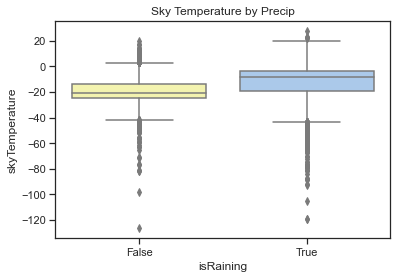

In [65]:
# Display boxplots by skytemp and temp to see how effective skytemp is at splitting data
box_df = df[['skytemperature','tempint','pluie']].copy()
box_df.columns = ['skyTemperature','internalTemperature', 'isRaining']
box_df.isRaining = box_df.isRaining.astype('bool')

boxplot = sns.boxplot(  y="skyTemperature", x='isRaining', palette=["y", "b"], data=box_df).set_title("Sky Temperature by Precip")

boxplot.get_figure().savefig(os.path.join( os.getcwd(), 'figs\\boxplot_skytemp.png'))

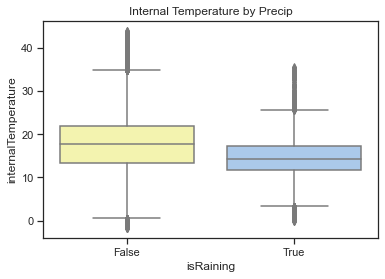

In [66]:
boxplot2 = sns.boxplot(  y="internalTemperature", x='isRaining', palette=["y", "b"], data=box_df).set_title("Internal Temperature by Precip")

boxplot2.get_figure().savefig(os.path.join( os.getcwd(), 'figs\\boxplot_tempint.png'))

# Exploring Rainy-Days split

In [3]:
def split_rainOnly(df, nextcol):
    # Function takes a dataframe to be used for a classification ML model 
    # where 'pluie' column contains the current precip status, and 'next col' an optional
    # classification column for lead times (if no lead times, input will be 'pluie')
    
    # Set pluie of each day to 1 if it had any rainfall that day
    by_day = df.groupby( df.date.dt.date ).max()
    
    # take all where current row is raining or next X mins is raining
    df_rain = df[ df.date.dt.date.isin( by_day[ by_day.pluie.eq(1) ].date.dt.date ) | df.date.dt.date.isin( by_day[ by_day[nextcol].eq(1) ].date.dt.date ) ]
    
    return df_rain

In [4]:
# compute the split of rain only rows
df_R = split_rainOnly( df, 'pluie' )

In [69]:
print('proportion of rain rows in df_R: ', round(100* len(df_R[df_R.pluie.eq(1)])/ len(df_R),4),"%" )
print('proportion of rain rows in regular dataset: ', round(100* len(df[df.pluie.eq(1)])/ len(df),4),"%" )

proportion of rain rows in df_R:  13.2858 %
proportion of rain rows in regular dataset:  6.3016 %


### Compute proportion of rain days

In [78]:
by_day[['pluie']].describe()

,pluie
count,1299.000000
mean,17.423403
std,35.980190
min,0.000000
25%,0.000000
50%,0.000000
75%,16.000000
max,283.000000


In [85]:
by_day = df.groupby( df.date.dt.date ).sum()

print("Proportion of 'rain days' overall: {0}%".format( round(100*(len(by_day[ by_day.pluie.gt(0) ])/len(by_day)),4)))

print("Proportion of 'rain days' with more than 1 rain row: {0}%".format( round(100*(len(by_day[ by_day.pluie.gt(1) ])/len(by_day)),4)))

Proportion of 'rain days' overall: 46.8822%
Proportion of 'rain days' with more than 1 rain row: 41.5704%


In [272]:
# Compute the rain days in a month to compare to RAAF Gingin histograms

# aggregate all rainy days
rain_days = df_R.groupby( df_R.date.dt.date )[['date','pluie']].sum()
rain_days.index = pd.to_datetime( rain_days.index )

# count number of days per month
days_pmonth = rain_days.groupby( [rain_days.index.year, rain_days.index.month] ).pluie.count()

# count number of (days with more than 1 rain row) per month
rain_days_gt1 = rain_days[ rain_days.pluie.gt(1) ]
days_pmonth_gt1 = rain_days_gt1.groupby( [rain_days_gt1.index.year, rain_days_gt1.index.month] ).pluie.count()

days_pmonth.rename_axis(['year','month'],inplace=True)
days_pmonth_gt1.rename_axis(['year','month'],inplace=True)

In [298]:
sns.set_theme(style="ticks", palette="pastel")

In [292]:
plt.style.use("default")

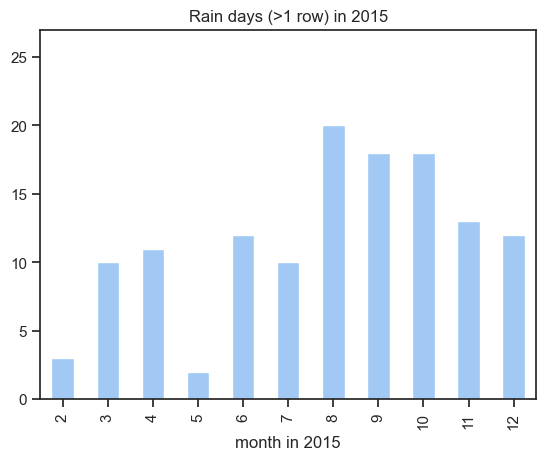

In [299]:
days_2015 = days_pmonth_gt1[ days_pmonth_gt1.index.isin( [2015], level = 'year' ) ].plot.bar()
days_2015.set_title("Rain days (>1 row) in 2015")
days_2015.set_xticklabels(range(2,13))
days_2015.set_ylim([0,27])
days_2015.set_xlabel("month in 2015")
plt.savefig(os.path.join( os.getcwd(), 'figs\\2015_raindays_gt1.png'))
plt.show()

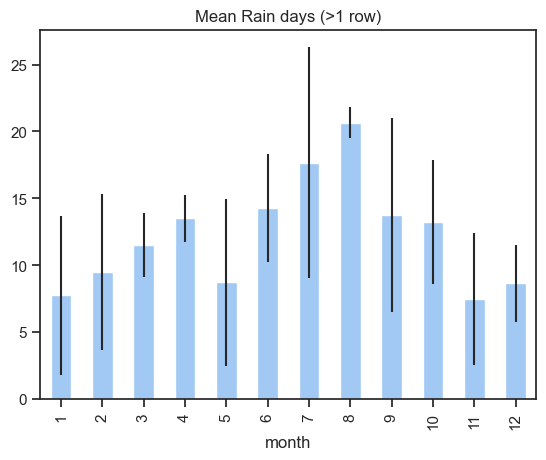

In [300]:
days_pmonth_gt1.groupby(['month']).mean().plot.bar(yerr = days_pmonth_gt1.groupby(['month']).std()).set_title("Mean Rain days (>1 row)")
plt.savefig(os.path.join( os.getcwd(), 'figs\\mean_raindays_gt1.png'))
plt.show()

Note quite high counts in the summer and low counts in May - potentially suggests presence of false positives

# Check for patterns in wind direction with time of day (could be interesting)

<AxesSubplot:xlabel='date'>

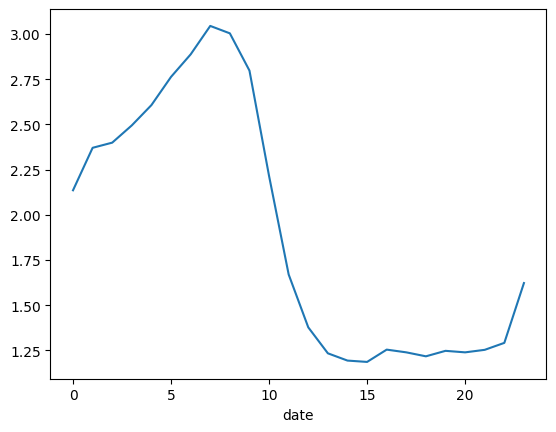

In [429]:
Mar_only = df[ df.date.dt.month.eq(3) ]
Mar_only.groupby( Mar_only.date.dt.hour ).vent.mean().plot()

<AxesSubplot:xlabel='date'>

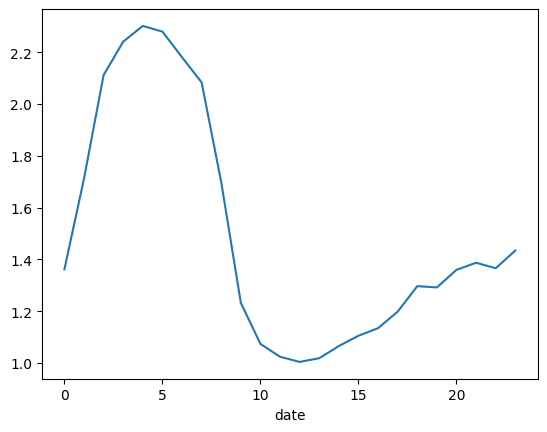

In [430]:
Jul_only = df[ df.date.dt.month.eq(7) ]
Jul_only.groupby( Jul_only.date.dt.hour ).vent.mean().plot()

# Month dataset

In [9]:
# Now create month columns

# requires calendar module for mapping to month names
# Store mapping in a dict
month_dict = {index: month for index, month in enumerate(month_abbr) if month}

# map the value of each month to 1 or 0 for a new column.
# will create 12 new columns, one of which will be 1 for each row
for index in month_dict.keys():
    df[ month_dict[index] ] = (df['date'].dt.month == index).astype(int)

In [10]:
# Now let's train a model with stock parameters to find importance of months

# Use all except ids, date and pluie as training
X_month = df.drop(['idmeteo','idtelescope','date','pluie'], axis=1)
y_month = df['pluie']

# Use a randomized splitting using sk-learns function
X_month_train, X_month_test, y_month_train, y_month_test = train_test_split(X_month, y_month, test_size=0.33, random_state = 29)

# Initialise the RFC model with 100 trees, and to run on parallel CPUs (faster compute)
rf_month = RandomForestClassifier(n_estimators=100, n_jobs = -1)

# and train it on the datasets
rf_month.fit(X_month_train,y_month_train)

RandomForestClassifier(n_jobs=-1)

In [11]:
# test the model on our split testing sets
y_month_pred=rf_month.predict(X_month_test)

# and compute the feature importances
feature_imp = pd.Series(rf_month.feature_importances_,index=[colname for colname in X_month.columns]).sort_values(ascending=False)

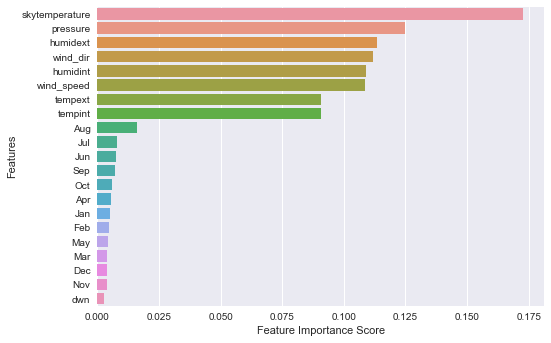

In [51]:
# plot the feature importances

# Creating a bar plot
sns.barplot(x=feature_imp, y=translate_cols(feature_imp.index))

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

Clearly, dew point is not a critical parameter, and the winter months are more important that the summer months, but overall not as important as temp, humidity and wind. All other variables will be kept

### Alternative feature importance evaluation to not favour continous variables

In [12]:
from sklearn.inspection import permutation_importance

In [13]:
result = permutation_importance(rf_month, X_month_test, y_month_test, n_repeats=10,
                                random_state=42, n_jobs=2)

In [22]:
# translate columns to english
def translate_cols(X_labels):
    new_Xlabels = list(X_labels)
    
    for i in range(len(X_labels)):
        lab = X_labels[i]
        if lab == 'vent':
            new_Xlabels[i] = "wind_speed"
        elif lab == 'dirvent':
            new_Xlabels[i] = "wind_dir"
        elif lab == 'pression':
            new_Xlabels[i] = "pressure"
            
    return pd.Index(new_Xlabels)


Index(['May', 'Mar', 'Oct', 'dwn', 'Dec', 'Feb', 'Jan', 'Jun', 'Nov', 'Sep',
       'Apr', 'Jul', 'Aug', 'tempext', 'tempint', 'wind_dir', 'pressure',
       'humidint', 'skytemperature', 'humidext', 'wind_speed'],
      dtype='object')

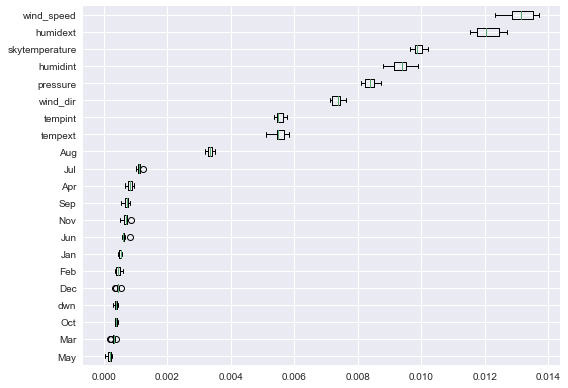

In [25]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=translate_cols(X_month_test.columns[sorted_idx]))
fig.tight_layout()
plt.show()

In [24]:
plt.style.use("seaborn")

##### To be able to quickly evaluate feature importance (and model performance) for different models, we will define some functions

In [5]:
def performance_eval(clf, y_test, y_pred):
    """
    Function to evaluate performance of a model on test data by a set of verification scores,
    and confusion matrix.
    Verification scores chosen based on a high class imbalance dataset (rainfall incidence).
    """  
    
    ## Compute the Confusion Matrix
    
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    # extract values from CM
    tn, fp, fn, tp = cm.ravel()
    
    # Will return the display of the confusion matrix
    disp = ConfusionMatrixDisplay( confusion_matrix=cm , display_labels = clf.classes_)
    
    ## Verification Scores
    
    # Initialize a pandas series to store the verification scores
    # such that they can be sorted and indexed
    veri_scores = pd.Series([0.1]*7, index = ['acc','bias', 'pod', 'far', 'ts', 'ets', 'or'])
    
    # Accuracy Score
    veri_scores['acc']  = accuracy_score(y_test,y_pred)
    
    # Balanced Accuracy Score
    veri_scores['b_acc'] = balanced_accuracy_score(y_test,y_pred)

    # Bias Score
    veri_scores['bias'] = (tp + fp)/(tp + fn)

    # Probability of Detection
    veri_scores['pod']  = (tp)/(tp + fn)

    # False Alarm Ratio
    veri_scores['far']  = (fp)/(tp + fp)

    # Threat Score
    veri_scores['ts']   = (tp)/(tp + fp + fn)

    # Equitable Threat Score ( accounting for random tp's )
    r_tp = ((tp + fn)*(tp + fp)) / len(y_pred)
    veri_scores['ets'] = (tp - r_tp)/(tp + fp + fn - r_tp)

    # Odds Ratio
    veri_scores['or']   = (tp * tn) / (fn * fp) 

    veri_scores = veri_scores.sort_values(ascending = False)
    
    return(disp, veri_scores)

In [6]:
def find_feature_imp(clf, X, make_plot = False, filename=""):
    ## Feature importances
    feature_imp = pd.Series(clf.feature_importances_, index=[colname for colname in X.columns]).sort_values(ascending=False)
    
    if make_plot:
        # Creating a bar plot
        sns.barplot(x=feature_imp, y=feature_imp.index)

        # Add labels to your graph
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title("Visualizing Important Features")
        if len(filename) > 0:
            plt.savefig( os.path.join( os.getcwd(), 'figs\\'+'filename') )
        plt.show()
    
    return feature_imp

In [7]:
def build_prediction( threshold, rfc, X_test ):
    """
    Function to output a Random Forest Classifier's predictions on X_test data, either automatically or
    given a probability threshold.
    """
    
    if threshold == None:
        # make predictions on the test data
        y_pred = rfc.predict(X_test)
    else:
        # make predictions on the test data, according to the threshold
        y_pred_prob = rfc.predict_proba(X_test)
        y_pred = (y_pred_prob[:,1] >= threshold).astype('int')
        
    return y_pred
    

In [8]:
def build_model(df_R, df_all, pred_col, n_trees, threshold=None, stratify=False, max_depth=None):
    """
    Function to build a Random Forest Classifier for rainfall contained in the prediction column (pred_col).
    
    If df_R is set to None, the model is trained / tested on a split of all data,
    if df_R is not None, the model is trained on a split of only rain days, and then tested on all remaining days.
    
    If threshold is None the default probability selection is used, otherwise the threshold is used as the cutoff
    probability to decide it will rain.
    
    Stratify will determine whether a more balanced split of rain / no rain rows is applied to training / test.
    """
    if df_R is not None:
        
        X_R = df_R.drop([pred_col, 'idmeteo','idtelescope','date'], axis = 1)
        y_R = df_R[pred_col]

        # notice names for training sets do not contain '_R' to allow generalisation, while test sets contain'_R'
        # to differentiate and allow separate testing
        if stratify:
            X_train, X_R_test, y_train, y_R_test = train_test_split(X_R, y_R, test_size=0.33, stratify = y_R)
        else: 
            X_train, X_R_test, y_train, y_R_test = train_test_split(X_R, y_R, test_size=0.33)
        
        # set the test sets to be all rows not used for training
        df_test = df_all[ ~df_all.index.isin( X_train.index ) ]
        X_test = df_test.drop([pred_col, 'idmeteo','idtelescope','date'], axis = 1)
        y_test = df_test[pred_col]
    
    else:
        X = df_all.drop([pred_col, 'idmeteo','idtelescope','date'], axis = 1)
        y = df_all[pred_col]
        
        if stratify:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)
        else: 
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
            
    # intialise the classifier (n_jobs allows parallelisation for faster compute)
    rfc = RandomForestClassifier(n_estimators=n_trees, n_jobs = -1, max_depth = max_depth) 

    # train the model
    rfc.fit(X_train,y_train)

    # Do a test on just rain data
    y_pred = build_prediction(threshold, rfc, X_test)

    if df_R is not None:
        y_R_pred = build_prediction(threshold, rfc, X_R_test)
        # Evaluate the performance of the model on just rain day test data and store results
        # as attributes of the model
        rfc.conf_matrix_R, rfc.veri_scores_R = performance_eval(rfc, y_R_test, y_R_pred)
        
    # and evaluate the model performance on all of the day for both cases
    
    rfc.conf_matrix, rfc.veri_scores = performance_eval(rfc, y_test, y_pred)

    rfc.feature_imp = find_feature_imp(rfc, X_test)
    
    # Attach the training and testing sets to the models as dictionary attributes
    rfc.sets = {'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test , 'y_pred':y_pred}
    
    return rfc
        

## Now, for month dataset, compute the rain trained model

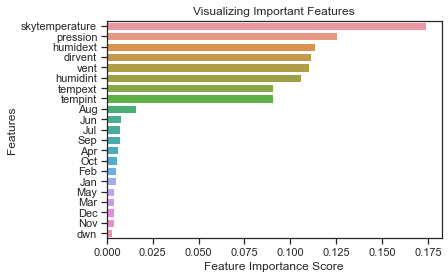

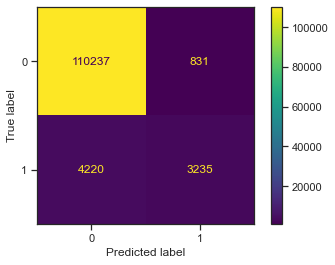

In [180]:
rf_month = build_model(None, df, 'pluie',100)

In [176]:
rf_monthR = build_model( df_R, df, 'pluie', 100)

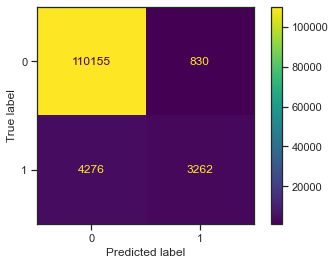

In [182]:
rf_month.conf_matrix.plot()

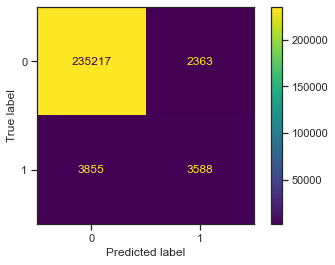

In [185]:
rf_monthR.conf_matrix.plot()

In [183]:
rf_month.veri_scores

or      101.244720
acc       0.956920
bias      0.542850
pod       0.432741
ts        0.389818
ets       0.370232
far       0.202835
dtype: float64

In [179]:
rf_monthR.veri_scores

or      92.647358
acc      0.974623
bias     0.799543
pod      0.482064
far      0.397076
ts       0.365898
ets      0.353989
dtype: float64

In [50]:
sns.barplot(x=rf_month.feature_imp, y=translate_cols(rf_month.feature_imp.index))
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features (All Months)")
plt.show()

AttributeError: 'RandomForestClassifier' object has no attribute 'feature_imp'

So we get significantly better performance by first training on rain only data and testing on all the data

# Seasons set

### Now do the same as above but using seasons instead of months

In [232]:
# Tried using different splitting of seasons

In [26]:
df_s = df.copy()

# Autumn
df_s['A'] = 0
df_s.loc[ df_s.Mar.eq(1) | df_s.Apr.eq(1) | df_s.May.eq(1), 'A' ] = 1

# Summer
df_s['Su'] = 0
df_s.loc[ df_s.Dec.eq(1) | df_s.Jan.eq(1)| df_s.Feb.eq(1), 'Su' ] = 1

# Spring
df_s['Sp'] = 0
df_s.loc[df_s.Sep.eq(1) | df_s.Oct.eq(1) | df_s.Nov.eq(1), 'Sp' ] = 1

# Winter
df_s['W'] = 0
df_s.loc[ df_s.Jun.eq(1) | df_s.Jul.eq(1) | df_s.Aug.eq(1), 'W' ] = 1

# Set as a new dataframe without the month columns
df_s = df_s.drop(month_abbr[1:], axis=1)

In [27]:
df_s2 = df.copy()

# Late Summer
df_s2['LS'] = 0
df_s2.loc[ df_s2.Feb.eq(1) | df_s2.Mar.eq(1) | df_s2.Apr.eq(1), 'LS' ] = 1

# Early Summer
df_s2['ES'] = 0
df_s2.loc[ df_s2.Nov.eq(1) | df_s2.Dec.eq(1) | df_s2.Jan.eq(1) , 'ES' ] = 1

# Late Winter
df_s2['LW'] = 0
df_s2.loc[ df_s2.Aug.eq(1) | df_s2.Sep.eq(1) | df_s2.Oct.eq(1), 'LW' ] = 1

# Winter
df_s2['EW'] = 0
df_s2.loc[ df_s2.May.eq(1) | df_s2.Jun.eq(1) | df_s2.Jul.eq(1), 'EW' ] = 1

# Set as a new dataframe without the month columns
df_s2 = df_s2.drop(month_abbr[1:], axis=1)

In [28]:
# compute the split of rain only rows
df_sR = split_rainOnly( df_s, 'pluie' )
df_s2R = split_rainOnly( df_s2, 'pluie')

In [29]:
rf_s = build_model( None, df_s, 'pluie',100 )

In [30]:
rf_s2 = build_model( None, df_s2, 'pluie', 100)

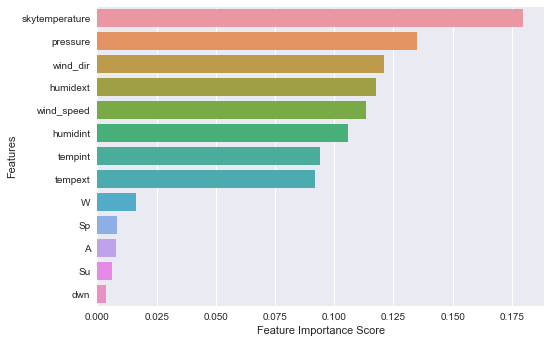

In [47]:
sns.barplot(x=rf_s.feature_imp, y=translate_cols(rf_s.feature_imp.index))

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

In [31]:
result_s = permutation_importance(rf_s, rf_s.sets['X_test'], rf_s.sets['y_test'], n_repeats=10,
                                random_state=42, n_jobs=2)

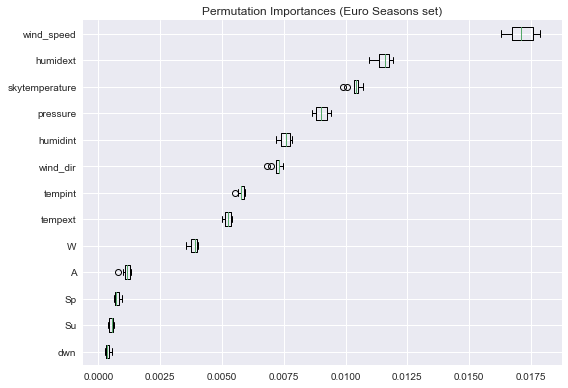

In [32]:
sorted_idx_s = result_s.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result_s.importances[sorted_idx_s].T,
           vert=False, labels=translate_cols(rf_s.sets['X_test'].columns[sorted_idx_s]))
ax.set_title("Permutation Importances (Euro Seasons set)")
fig.tight_layout()
plt.show()

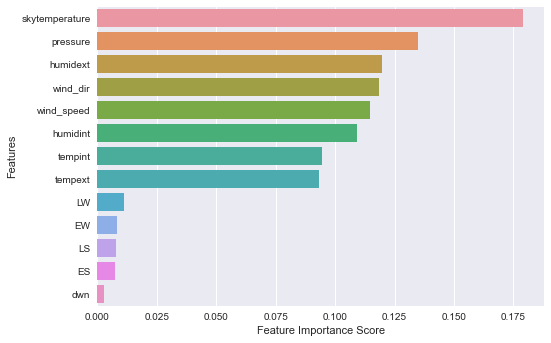

In [48]:
rf_s2 = build_model( None, df_s2, 'pluie',100 )
sns.barplot(x=rf_s2.feature_imp, y=translate_cols(rf_s2.feature_imp.index))

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

In [33]:
result_s2 = permutation_importance(rf_s2, rf_s2.sets['X_test'], rf_s2.sets['y_test'], n_repeats=10,
                                random_state=42, n_jobs=2)

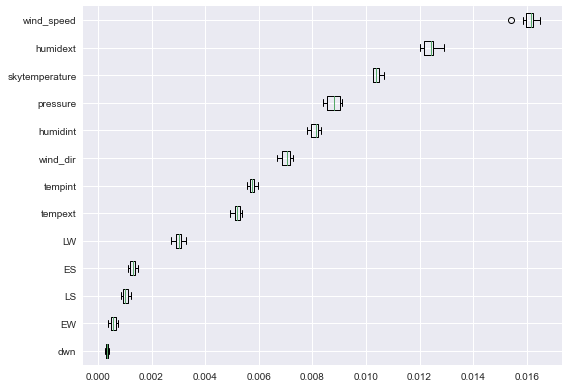

In [52]:
sorted_idx_s2 = result_s2.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result_s2.importances[sorted_idx_s2].T,
           vert=False, labels=translate_cols(rf_s2.sets['X_test'].columns[sorted_idx_s2]))
fig.tight_layout()
plt.show()

In [228]:
rf_sR = build_model( df_sR, df_s, 'pluie', 100)

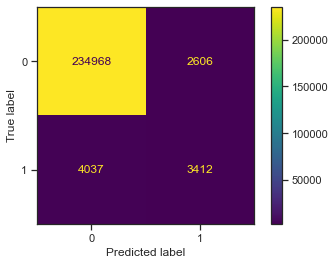

In [229]:
rf_sR.conf_matrix.plot()

In [230]:
rf_sR.veri_scores

or      76.205196
acc      0.972888
bias     0.807894
pod      0.458048
far      0.433034
ts       0.339334
ets      0.327090
dtype: float64

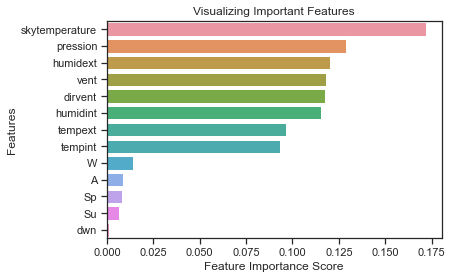

In [231]:
sns.barplot(x=rf_sR.feature_imp, y=rf_sR.feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [236]:
rf_s2R = build_model( df_s2R, df_s2, 'pluie', 100)

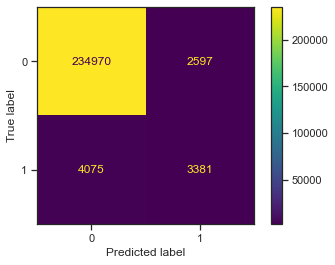

In [237]:
rf_s2R.conf_matrix.plot()

In [238]:
rf_s2R.veri_scores

or      75.068550
acc      0.972770
bias     0.801770
pod      0.453460
far      0.434426
ts       0.336318
ets      0.324087
dtype: float64

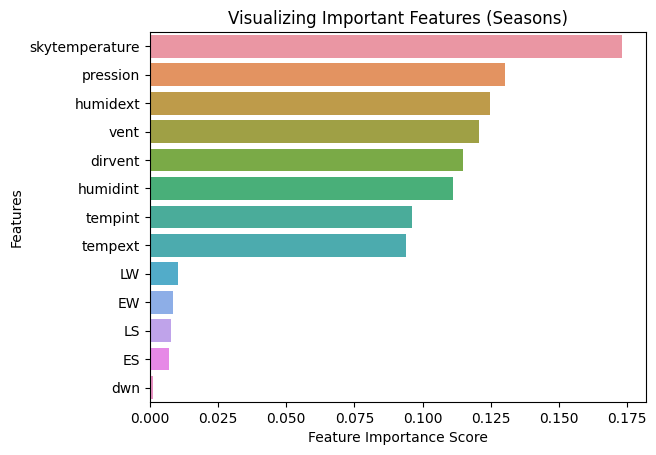

In [418]:
sns.barplot(x=rf_s2R.feature_imp, y=rf_s2R.feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features (Seasons)")
plt.show()

So Winter is clearly most important seasons, but since the overall performance is lower than that for  individual months, we stick with individual months.

In [28]:
rf_monthR = build_model(df_R, df, 'pluie', 100)
rf_sR = build_model(df_sR, df_s, 'pluie', 100)
rf_s2R = build_model(df_s2R, df_s2, 'pluie', 100)

In [29]:
rf_month = build_model(None, df, 'pluie', 100)
rf_s = build_model(None, df_s, 'pluie', 100)
rf_s2 = build_model(None, df_s2, 'pluie', 100)

In [30]:
rf_monthR.veri_scores

or       94.599408
acc       0.974843
bias      0.788412
b_acc     0.735122
pod       0.479903
far       0.391304
ts        0.366756
ets       0.354956
dtype: float64

In [31]:
rf_month.veri_scores

or       94.414055
acc       0.956979
b_acc     0.715264
bias      0.560992
pod       0.438740
ts        0.390946
ets       0.371161
far       0.217921
dtype: float64

In [22]:
vscores_month = pd.DataFrame( {'Month': rf_month.veri_scores.drop(['or','ts','bias'])} )
# vscores_month['type'] = "Month"
vscores_s = pd.DataFrame( {'Euro': rf_s.veri_scores.drop(['or','ts','bias'])} )
# vscores_s['type'] = "Euro"
vscores_s2 = pd.DataFrame( {'Wright': rf_s2.veri_scores.drop(['or','ts','bias'])} )
# vscores_s2['type'] = "Wright"

Text(0.5, 1.0, 'Seasonality Verification Scores')

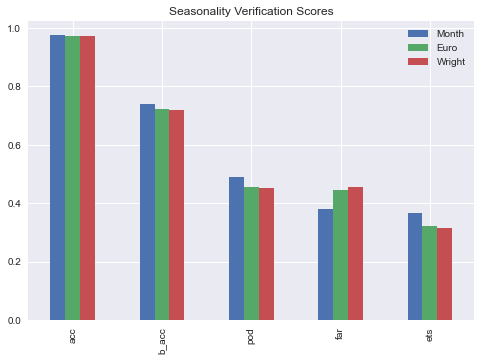

In [27]:
vscores_month.join(vscores_s).join( vscores_s2 ).plot.bar().set_title("Seasonality Verification Scores")

In [540]:
df.dwn.unique()

array([2, 0], dtype=int64)

# Adding new pluie columns

In [12]:
def find_nextXmins( row, df, X ):
    """
    Function that given a row in a dataframe containing a pluie field will output
    whether or not there was rain recorded in the following X minutes after.
    """
    
    # slice the dataframe to find all rows within X minutes
    nextXmins = df[ df.date.gt(row.date) & df.date.le( row.date + timedelta(minutes = X) ) ]
    if len(nextXmins) == 0:
        # didn't find any data within next X mins - do not assume behaviour inbetween this and next point
        next_pluie = np.nan
    else:
        # whether only one value or multiple, take the maximum (if raining at any point, will be 1)
        next_pluie = int(nextXmins.pluie.max())
        # consider changing this to sum instead? could give more insight
        
    return next_pluie

While adding nans may create bias, we will assume that there is no correlation between the frequency of measurement and precip, and simply ignore those rows where a value within the next X mins was not found

### Now we examine the deltas to find what appropriate X values may be

In [252]:
df_deltas = df.shift(-1).date - df.date
df_deltas.dropna(inplace=True)
df_deltas.sort_values(ascending = False).iloc[:20]

433441   83 days 09:54:13
131665   30 days 00:35:53
456579   21 days 09:05:58
191004   12 days 17:50:24
328162    9 days 00:39:50
131636    8 days 00:16:20
417401    5 days 14:31:01
108545    5 days 10:40:18
186402    5 days 01:41:16
370231    5 days 00:38:58
405241    3 days 14:04:20
454759    3 days 02:14:11
303819    2 days 22:32:52
358483    2 days 13:08:15
433553    2 days 02:33:01
444782    2 days 02:26:46
274937    2 days 00:44:26
366552    2 days 00:11:28
370240    1 days 22:01:52
438727    1 days 21:06:14
Name: date, dtype: timedelta64[ns]

In [259]:
df_deltas.describe()

count                       359159
mean     0 days 00:05:58.917515640
std      0 days 03:45:36.873324231
min                0 days 00:00:20
25%                0 days 00:05:00
50%                0 days 00:05:01
75%                0 days 00:05:01
max               83 days 09:54:13
Name: date, dtype: object

In [26]:
plt.style.use('seaborn')

In [67]:
plt.style.use('tableau-colorblind10')

In [482]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

<AxesSubplot:ylabel='Frequency'>

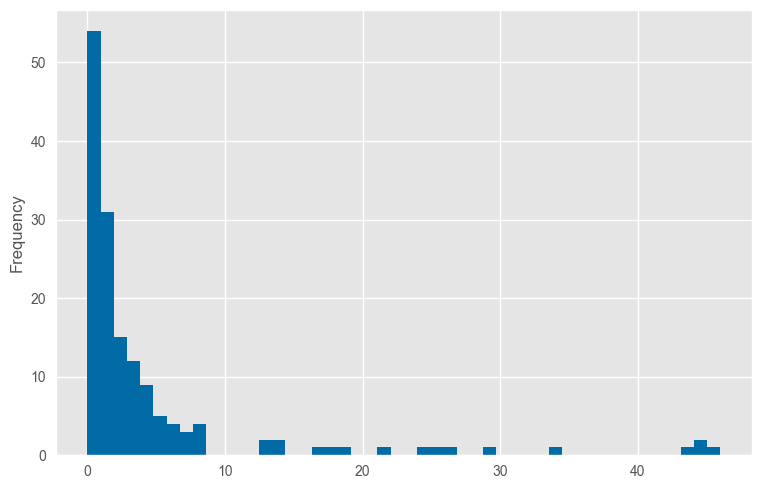

In [553]:
df_deltas[df_deltas.le(timedelta(hours = 48))  & df_deltas.gt(timedelta(minutes=30))].astype('timedelta64[h]').plot.hist(bins=48)

<AxesSubplot:ylabel='Frequency'>

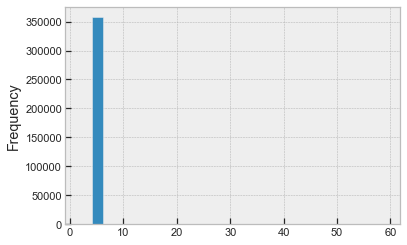

In [264]:
df_deltas[df_deltas.le(timedelta(hours = 1))  & df_deltas.gt(timedelta(minutes=2))].astype('timedelta64[m]').plot.hist(bins=27)

Text(0.5, 1.0, 'Weather Data Deltas (6 min < t < 1 hr)')

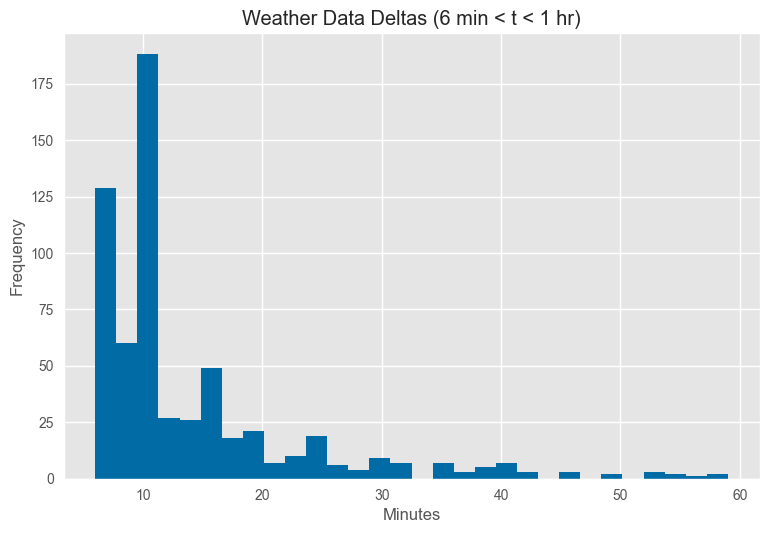

In [554]:
h = df_deltas[df_deltas.le(timedelta(hours = 1))  & df_deltas.gt(timedelta(minutes=6))].astype('timedelta64[m]').plot.hist(bins=30)
h.set_xlabel('Minutes')
h.set_title("Weather Data Deltas (6 min < t < 1 hr)")

<AxesSubplot:ylabel='Frequency'>

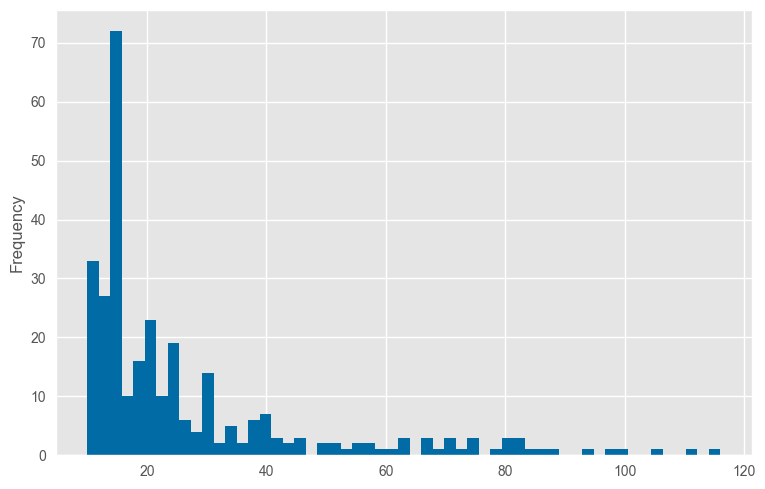

In [555]:
df_deltas[df_deltas.le(timedelta(hours = 2))  & df_deltas.gt(timedelta(seconds = 610))].astype('timedelta64[m]').plot.hist(bins=55)

In [556]:
print("Proportion under 5min 10 seconds:", len( df_deltas[ df_deltas.le(timedelta(seconds = 310)) ] ) / len(df_deltas) )
print("Proportion under 10min 10 seconds:", len( df_deltas[ df_deltas.le(timedelta(seconds = 610)) ] ) / len(df_deltas) )
print("Proportion under 30min:", len( df_deltas[ df_deltas.le(timedelta(minutes = 30)) ] ) / len(df_deltas) )

Proportion under 5min 10 seconds: 0.9714805977296963
Proportion under 10min 10 seconds: 0.9989085613892454
Proportion under 30min: 0.9995211034667097


We observe the main peak at just over 5 minutes - this is the standard time between measurements.
However, we observe a second peak at just over 10 minutes also, and since we can capture almost all of the data this way, we choose a to do analysis based on a 10 minute lead time.

The choice of a cutoff of 30 minutes is based an the last spike in the last histogram occuring there, and it being a conventional lead time.

In [275]:
df_10min = df.copy()

# No foreseeable way to do vectorize this so have to use an apply
# 10,1666667 minutes corresponds to 610 seconds to cover small fluctuations in measurement time

df_10min.loc[:,'pluie_10min'] = df_10min.apply(find_nextXmins, args=(df_10min,10.16666667,), axis=1)

df_10min.dropna(inplace=True)

df_10min.head()

,idmeteo,idtelescope,date,tempext,tempint,pression,humidext,humidint,pluie,vent,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,pluie_10min
102293,108695,3,2015-01-01 00:00:59,21.0,21.0,1005.1,53.4,53.4,0,3.0,...,0,0,0,0,0,0,0,0,0,0.0
102294,108696,3,2015-01-01 00:05:59,21.4,21.4,1005.0,55.1,55.1,0,2.5,...,0,0,0,0,0,0,0,0,0,0.0
102295,108697,3,2015-01-01 00:11:00,21.8,21.8,1005.0,52.3,52.3,0,2.0,...,0,0,0,0,0,0,0,0,0,0.0
102296,108698,3,2015-01-01 00:16:01,21.7,21.7,1005.1,52.8,52.8,0,3.1,...,0,0,0,0,0,0,0,0,0,0.0
102297,108699,3,2015-01-01 00:21:01,21.9,21.9,1005.0,51.2,51.2,0,2.3,...,0,0,0,0,0,0,0,0,0,0.0


In [277]:
df_10min.to_csv( os.path.join( os.getcwd(), 'df_10min.csv'), index = False )

In [35]:
df_10min = pd.read_csv( os.path.join( os.getcwd(), 'df_10min.csv'), parse_dates=['date'] )

In [278]:
df_30min = df.copy()
df_30min.loc[:,'pluie_30min'] = df_30min.apply(find_nextXmins, args=(df_30min,30,), axis=1)

df_30min.dropna(inplace=True)

df_30min.head()

,idmeteo,idtelescope,date,tempext,tempint,pression,humidext,humidint,pluie,vent,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,pluie_30min
102293,108695,3,2015-01-01 00:00:59,21.0,21.0,1005.1,53.4,53.4,0,3.0,...,0,0,0,0,0,0,0,0,0,0.0
102294,108696,3,2015-01-01 00:05:59,21.4,21.4,1005.0,55.1,55.1,0,2.5,...,0,0,0,0,0,0,0,0,0,0.0
102295,108697,3,2015-01-01 00:11:00,21.8,21.8,1005.0,52.3,52.3,0,2.0,...,0,0,0,0,0,0,0,0,0,0.0
102296,108698,3,2015-01-01 00:16:01,21.7,21.7,1005.1,52.8,52.8,0,3.1,...,0,0,0,0,0,0,0,0,0,0.0
102297,108699,3,2015-01-01 00:21:01,21.9,21.9,1005.0,51.2,51.2,0,2.3,...,0,0,0,0,0,0,0,0,0,0.0


In [279]:
df_30min.to_csv( os.path.join( os.getcwd(), 'df_30min.csv'), index = False )

In [36]:
df_30min = pd.read_csv( os.path.join( os.getcwd(), 'df_30min.csv'), parse_dates = ['date'] )

In [ ]:
# Try a 5 minute model

In [580]:
df_5min = df.copy()
df_5min.loc[:,'pluie_5min'] = df_5min.apply(find_nextXmins, args=(df_5min,5.2,), axis=1)

df_5min.dropna(inplace=True)

df_5min.head()

,idmeteo,idtelescope,date,tempext,tempint,pression,humidext,humidint,pluie,vent,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,pluie_5min
102293,108695,3,2015-01-01 00:00:59,21.0,21.0,1005.1,53.4,53.4,0,3.0,...,0,0,0,0,0,0,0,0,0,0.0
102294,108696,3,2015-01-01 00:05:59,21.4,21.4,1005.0,55.1,55.1,0,2.5,...,0,0,0,0,0,0,0,0,0,0.0
102295,108697,3,2015-01-01 00:11:00,21.8,21.8,1005.0,52.3,52.3,0,2.0,...,0,0,0,0,0,0,0,0,0,0.0
102296,108698,3,2015-01-01 00:16:01,21.7,21.7,1005.1,52.8,52.8,0,3.1,...,0,0,0,0,0,0,0,0,0,0.0
102297,108699,3,2015-01-01 00:21:01,21.9,21.9,1005.0,51.2,51.2,0,2.3,...,0,0,0,0,0,0,0,0,0,0.0


In [581]:
df_5min.to_csv( os.path.join( os.getcwd(), 'df_5min.csv'), index = False )

In [37]:
df_5min = pd.read_csv( os.path.join( os.getcwd(), 'df_5min.csv'), parse_dates=['date'] )

In [467]:
df_s2_R = split_rainOnly( df_s2, 'pluie')

In [468]:
rf_s2_R = build_model( df_s2_R, df_s2, 'pluie',100 )

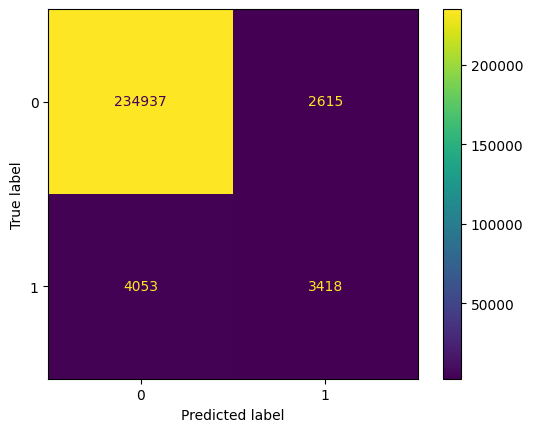

In [469]:
rf_s2_R.conf_matrix.plot()

# Model building

### Now we compute rain day only trained models for all three sets (no lead, 10min, and 30min)

In [38]:
df_5min_R = split_rainOnly( df_5min, 'pluie_5min')

In [39]:
rf_5min_R = build_model( df_5min_R, df_5min, 'pluie_5min', 100)


In [102]:
rf_5min_R.veri_scores

or       346.515486
acc        0.984036
bias       0.915412
b_acc      0.849246
pod        0.705352
ts         0.582907
ets        0.572683
far        0.229470
dtype: float64

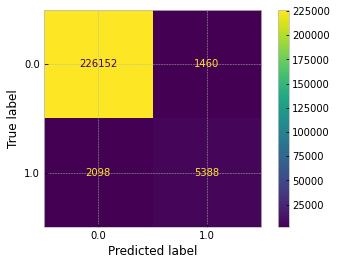

In [95]:
rf_5min_R.conf_matrix.plot()

In [32]:
balanced_accuracy_score(rf_5min_R.sets['y_test'], rf_5min_R.sets['y_pred'])

0.8566645483463056

In [40]:
df_10min_R = split_rainOnly( df_10min, 'pluie_10min' )
df_30min_R = split_rainOnly( df_30min, 'pluie_30min' )

In [41]:
rf_10min_R = build_model( df_10min_R, df_10min, 'pluie_10min', 100)
rf_30min_R = build_model( df_30min_R, df_30min, 'pluie_30min', 100)

In [47]:
rf_10min_R_md = build_model( df_10min_R, df_10min, 'pluie_10min', 100, 0.16)

In [48]:
rf_10min_R_md.veri_scores

or      78.798371
bias     2.007305
acc      0.946272
pod      0.798475
far      0.602216
ts       0.361492
ets      0.338594
dtype: float64

In [99]:
rf_10min_R.veri_scores

or       346.970265
acc        0.981818
b_acc      0.829381
bias       0.808419
pod        0.664436
ts         0.580810
ets        0.569269
far        0.178104
dtype: float64

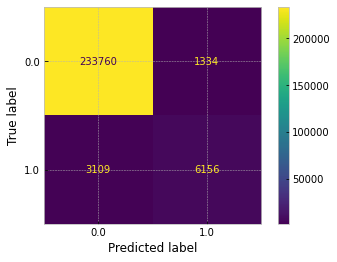

In [100]:
rf_10min_R.conf_matrix.plot()

In [43]:
result_10min = permutation_importance(rf_10min_R, rf_10min_R.sets['X_test'], rf_10min_R.sets['y_test'], n_repeats=10,
                                random_state=42, n_jobs=2)

IndentationError: unexpected indent (<ipython-input-43-4b08e84ea207>, line 2)

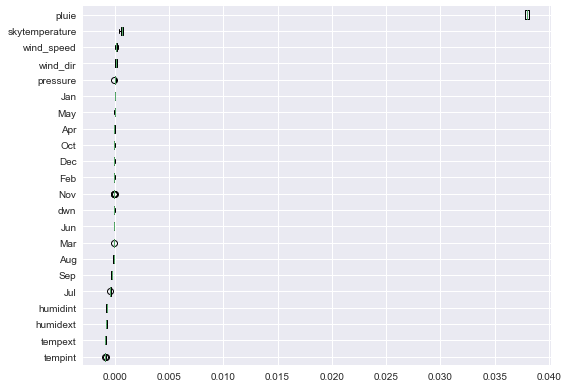

In [44]:
sorted_idx_10min = result_10min.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result_10min.importances[sorted_idx_10min].T,
           vert=False, labels=translate_cols(rf_10min_R.sets['X_test'].columns[sorted_idx_10min]))
fig.tight_layout()
plt.show()

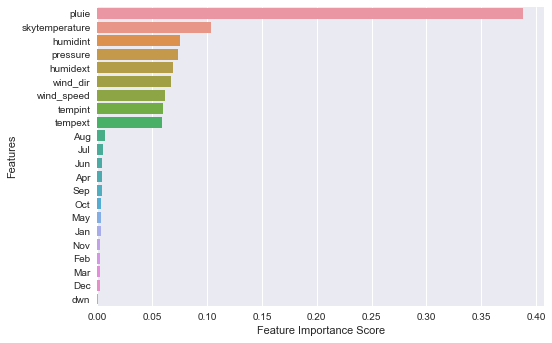

In [46]:
feat_imp10min = rf_10min_R.feature_imp
sns.barplot(x=feat_imp10min, y=translate_cols(feat_imp10min.index))

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
#plt.title("Visualizing Important Features - 10 min")
plt.show()

In [596]:
rf_30min_R.veri_scores

or      187.018126
acc       0.972909
bias      0.888190
pod       0.680338
ts        0.563262
ets       0.546122
far       0.234018
dtype: float64

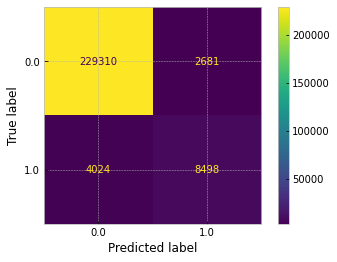

In [94]:
rf_30min_R.conf_matrix.plot()

In [615]:
## Testing a model having dropped dew point variable - consider impact on performance negligable?

rf_10min_nd = build_model( df_10min_R.drop(['dwn'],axis = 1), df_10min.drop(['dwn'],axis = 1), 'pluie_10min',100 )
rf_10min_nd.veri_scores

or      269.222022
acc       0.980189
bias      0.865876
pod       0.674255
ts        0.565830
ets       0.553403
far       0.221303
dtype: float64

## Impact of n_trees

In [50]:
veri_scores_10min = []

for n in range(2,150):
    rf_10min_Rn = build_model( df_10min_R, df_10min, 'pluie_10min', n )
    veri_scores_10min.append( rf_10min_Rn )

In [55]:
veri_scores_10min_df = pd.DataFrame([rf.veri_scores for rf in veri_scores_10min])
veri_scores_10min_df.index = range(2,150)

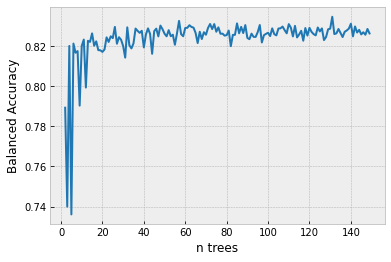

In [84]:
bacc_plot = veri_scores_10min_df.b_acc.plot( color = 'tab:blue')
bacc_plot.set_xlabel("n trees")
bacc_plot.set_ylabel("Balanced Accuracy")
plt.show()

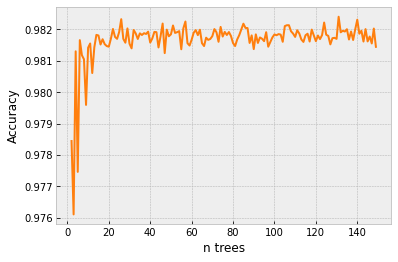

In [85]:
acc_plot = veri_scores_10min_df.acc.plot(color='tab:orange')
acc_plot.set_xlabel("n trees")
acc_plot.set_ylabel("Accuracy")
plt.show()

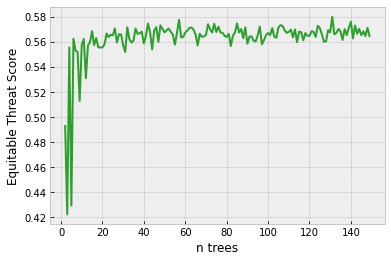

In [86]:
ets_plot = veri_scores_10min_df.ets.plot(color='tab:green')
ets_plot.set_xlabel("n trees")
ets_plot.set_ylabel("Equitable Threat Score")
plt.show()

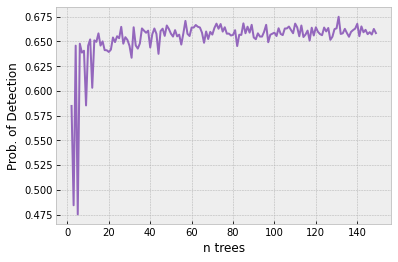

In [87]:
pod_plot = veri_scores_10min_df.pod.plot(color='tab:purple')
pod_plot.set_xlabel("n trees")
pod_plot.set_ylabel("Prob. of Detection")
plt.show()

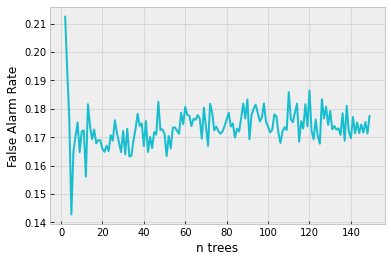

In [88]:
far_plot = veri_scores_10min_df.far.plot(color='cyan')
far_plot.set_xlabel("n trees")
far_plot.set_ylabel("False Alarm Rate")
plt.show()

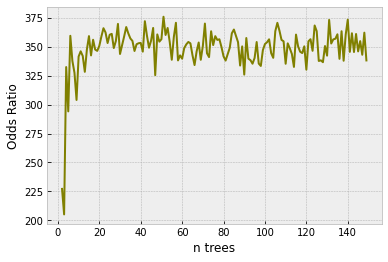

In [89]:
or_plot = veri_scores_10min_df['or'].plot(color='olive')
or_plot.set_xlabel("n trees")
or_plot.set_ylabel("Odds Ratio")
plt.show()

In [325]:
rf_month = build_model( df_R, df, 'pluie', 100 )

In [326]:
print(balanced_accuracy_score(rf_month.sets['y_test'], rf_month.sets['y_pred']))
print(balanced_accuracy_score(rf_10min_R.sets['y_test'], rf_10min_R.sets['y_pred']))
print(balanced_accuracy_score(rf_30min_R.sets['y_test'], rf_30min_R.sets['y_pred']))

0.7303696060641458
0.8364340570762796
0.8345427631218769


# Finding Optimal Threshold

In [329]:
def find_optimal_threshold(df_R, df, col_name):
    opt = {'bal_acc':0, 'th':0}
    for th in np.linspace(0.01, 1, 100):
        rfc = build_model( df_R, df, col_name, 50, th )
        new_bal_acc = balanced_accuracy_score(rfc.sets['y_test'], rfc.sets['y_pred'])
        if new_bal_acc > opt['bal_acc']:
            opt['bal_acc'] = new_bal_acc
            opt['th'] = th
    
    return opt

In [330]:
opt_month = find_optimal_threshold(df_R, df, 'pluie')

In [331]:
opt_10min = find_optimal_threshold(df_10min_R, df_10min, 'pluie_10min')
opt_30min = find_optimal_threshold(df_30min_R, df_30min, 'pluie_30min')

In [386]:
print("optimal threshold for regular dataset: ", opt_month)
print("optimal threshold for 10 min dataset: ", opt_10min)
print("optimal threshold for 30 min dataset: ", opt_30min)

optimal threshold for regular dataset:  {'bal_acc': 0.852352366723027, 'th': 0.17}
optimal threshold for 10 min dataset:  {'bal_acc': 0.8985290230469768, 'th': 0.16}
optimal threshold for 30 min dataset:  {'bal_acc': 0.8996680653469724, 'th': 0.21000000000000002}


In [616]:
opt_5min = find_optimal_threshold( df_5min_R, df_5min, 'pluie_5min' )
print("optimal threshold for 5 min dataset: {0:.4f}\nwith balanced accuracy {1:.4f}".format(opt_5min['th'], opt_5min['bal_acc']))

optimal threshold for 5 min dataset: 0.1700
with balanced accuracy 0.9055


In [142]:
rf_5min_opt = build_model( df_5min_R, df_5min, 'pluie_5min', 100, 0.17)

In [143]:
rf_5min_opt.veri_scores

or       149.427795
bias       1.858990
acc        0.962292
b_acc      0.902548
pod        0.838731
far        0.548824
ts         0.415160
ets        0.397466
dtype: float64

In [144]:
rf_5min_opt.conf_matrix.confusion_matrix / df_5min_opt.conf_matrix.confusion_matrix.sum()

array([[0.93552476, 0.03256089],
       [0.00514679, 0.02676756]])

In [149]:
rf_10min_opt = build_model(df_10min_R, df_10min, 'pluie_10min', 100, 0.16)
rf_10min_opt.veri_scores

or       85.054432
bias      2.964569
acc       0.916070
b_acc     0.900964
pod       0.884607
far       0.701607
ts        0.287214
ets       0.259982
dtype: float64

In [150]:
rf_10min_opt.conf_matrix.confusion_matrix / rf_10min_opt.conf_matrix.confusion_matrix.sum()

array([[0.88225111, 0.07951825],
       [0.00441154, 0.03381909]])

In [384]:
print("proportion of False Negatives: {0:.4f} %".format(100*2998 / len(rf_10min_R.sets['X_test'])))
print("proportion of False Positives: {0:.4f} %".format(100*1719 / len(rf_10min_R.sets['X_test'])))

proportion of False Negatives: 1.2269 %
proportion of False Positives: 0.7035 %


SO this system would halve the incidence of rain falling without the roof closed,
and decrease closed while not raining to less than 25%.

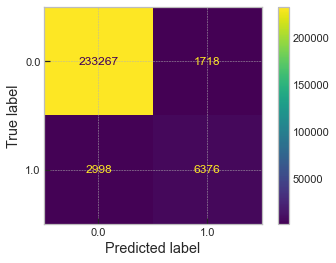

In [383]:
rf_10min_R.conf_matrix.plot()

In [151]:
rf_30min_opt = build_model(df_30min_R, df_30min, 'pluie_30min', 100, 0.21)

In [152]:
rf_30min_opt.veri_scores

or       84.732742
bias      3.036259
pod       0.916301
b_acc     0.900941
acc       0.887155
far       0.698214
ts        0.293690
ets       0.256646
dtype: float64

In [601]:
print(balanced_accuracy_score(rf_30min_opt.sets['y_test'], rf_30min_opt.sets['y_pred']))

0.9018335997756163


# Confusion Matrices

In [242]:
## BETTER CONFUSION MATRICES
## Source: https://github.com/wcipriano/pretty-print-confusion-matrix

import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh

def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df.sum()
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    if(per > 0):
        txt = '%s\n%.2f%%' %(cell_val, per)
    else:
        if(show_null_values == 0):
            txt = ''
        elif(show_null_values == 1):
            txt = '0'
        else:
            txt = '0\n0.0%'
    oText.set_text(txt)

    #main diagonal
    if(col == lin):
        #set color of the textin the diagonal to white
        oText.set_color('w')
        # set background color in the diagonal to blue
        facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
    else:
        oText.set_color('r')

    return text_add, text_del
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=26,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y', title="Confusion Matrix"):

    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 18)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        
        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title(title)
    ax.set_xlabel(xlbl, size = 20)
    ax.set_ylabel(ylbl, size = 20)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def new_cm( rfc, title ):
    df = pd.DataFrame( rfc.conf_matrix.confusion_matrix, index = ["No Rain","Rain"], columns = ["No Rain","Rain"] )
    pretty_plot_confusion_matrix(df, title=title )

In [230]:
rf_5min_R = build_model( df_5min_R, df_5min, 'pluie_5min', 100, max_depth = 8 )

In [231]:
rf_5min_R.veri_scores

or       391.989647
acc        0.984832
bias       0.940250
b_acc      0.861664
pod        0.730184
ts         0.603425
ets        0.593440
far        0.223415
dtype: float64

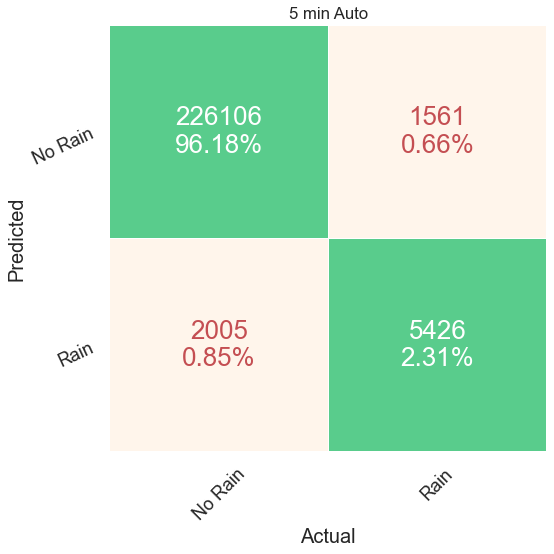

<Figure size 576x396 with 0 Axes>

In [245]:
new_cm(rf_5min_R, "5 min Auto")
plt.savefig('hello')

In [234]:
rf_5min_opt.veri_scores

or       149.427795
bias       1.858990
acc        0.962292
b_acc      0.902548
pod        0.838731
far        0.548824
ts         0.415160
ets        0.397466
dtype: float64

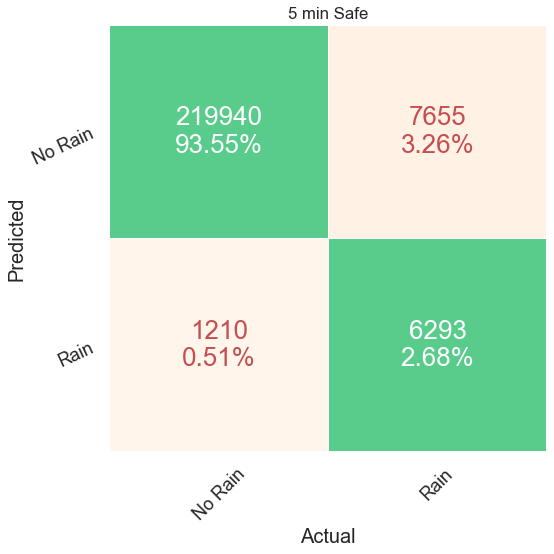

In [246]:
new_cm(rf_5min_opt, "5 min Safe")

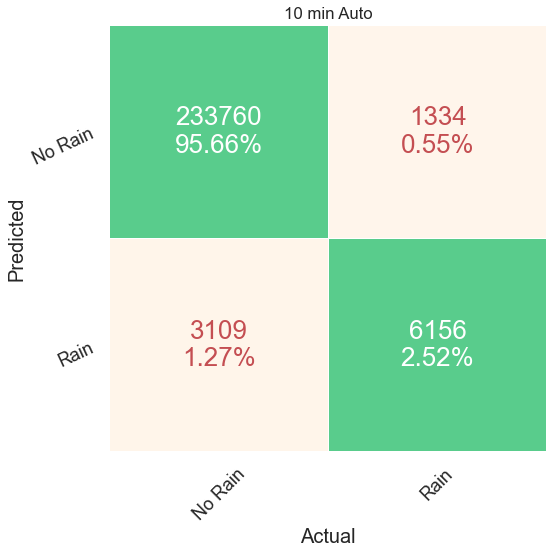

In [247]:
new_cm(rf_10min_R, "10 min Auto")

In [236]:
rf_10min_opt.veri_scores

or       85.054432
bias      2.964569
acc       0.916070
b_acc     0.900964
pod       0.884607
far       0.701607
ts        0.287214
ets       0.259982
dtype: float64

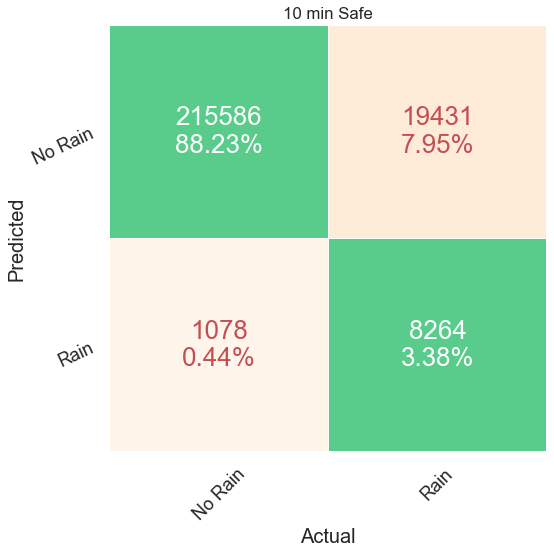

In [248]:
new_cm(rf_10min_opt, "10 min Safe")

In [215]:
rf_30min_R = build_model(df_30min_R, df_30min, 'pluie_30min', 100)

In [218]:
rf_30min_R.veri_scores

or       174.561243
acc        0.972030
bias       0.878431
b_acc      0.828658
pod        0.668750
ts         0.552831
ets        0.535386
far        0.238700
dtype: float64

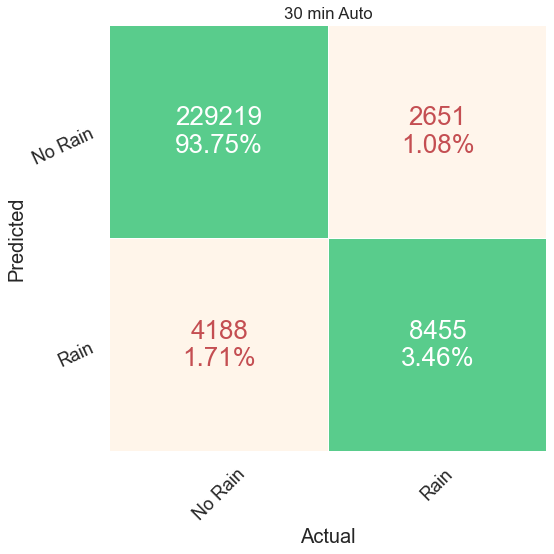

In [249]:
new_cm(rf_30min_R, "30 min Auto")

In [237]:
rf_30min_opt.veri_scores

or       84.732742
bias      3.036259
pod       0.916301
b_acc     0.900941
acc       0.887155
far       0.698214
ts        0.293690
ets       0.256646
dtype: float64

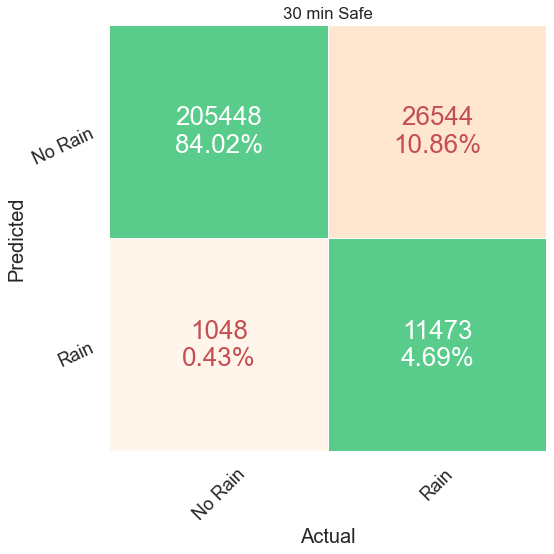

In [250]:
new_cm(rf_30min_opt, "30 min Safe")

## What threshold did the automatic model use?

In [387]:
rf_10min_R.veri_scores

or      288.766510
acc       0.980701
bias      0.863452
pod       0.680179
ts        0.574829
ets       0.562584
far       0.212256
dtype: float64

In [390]:
rf_10min_check = build_model(df_10min_R, df_10min, 'pluie_10min', 100, 0.5)
rf_10min_check.veri_scores

or      259.518133
acc       0.980136
bias      0.886075
pod       0.679204
ts        0.562781
ets       0.550354
far       0.233468
dtype: float64

In [391]:
# Close enough?

# Precision Recall Curve

In [154]:
def make_precrec_curve(rfc, title):
    """
    Function to produce the Precision Recall curve for a given model, where the train / test
    datasets are an attribute of the model stored in a dictionary, as output by build_model function.
    """
    ytest = rfc.sets['y_test']
    xtest = rfc.sets['X_test']
    yhat = rfc.sets['y_pred']
    
    # create set of predictions that it's never raining (no skill)
    ns_probs = [0 for _ in range(len(ytest))]

    # make predictions on the test data
    y_pred_prob = rfc.predict_proba(xtest)
    # keep probabilities for the positive outcome only
    y_pred = y_pred_prob[:,1]
    
    rf_precision, rf_recall, _ = precision_recall_curve(ytest, y_pred)
    rf_f1, rf_auc = f1_score(ytest, yhat), auc(rf_recall, rf_precision)
    
    # plot the precision-recall curves
    no_skill = len(ytest[ytest==1]) / len(ytest)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')

    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

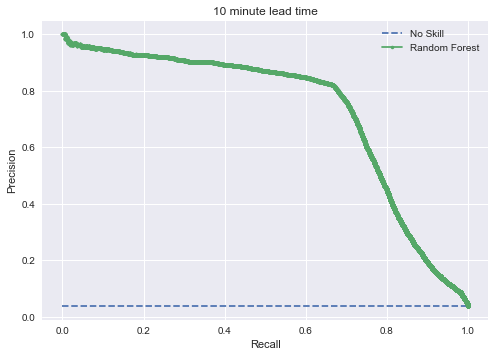

In [158]:
make_precrec_curve(rf_10min_R, "10 minute lead time")

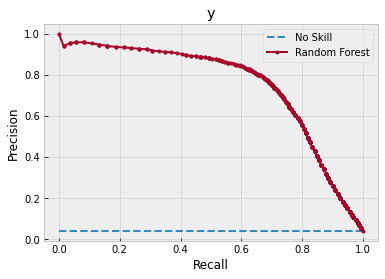

In [156]:
make_precrec_curve(rf_10min_opt, "y")

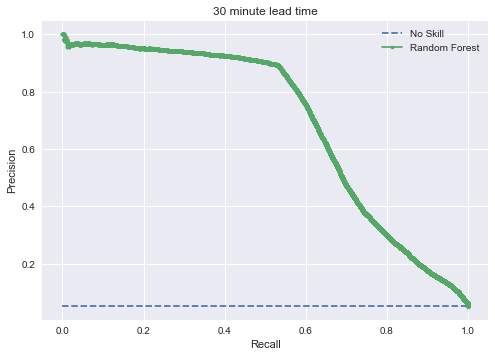

In [160]:
make_precrec_curve(rf_30min_R, "30 minute lead time")

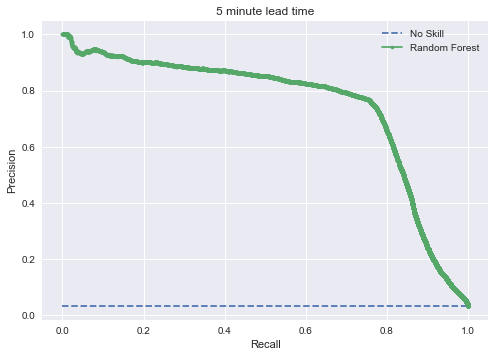

In [161]:
make_precrec_curve(rf_5min_R, "5 minute lead time")

# Cross Validation ?

### Idk if necessary but here it is I guess

In [109]:
# Do this using the parameters found by gridsearch

In [105]:
from sklearn.model_selection import cross_val_score

In [140]:
cvs_5min_R = cross_val_score(rf_5min_R, rf_5min_R.sets['X_train'], rf_5min_R.sets['y_train'], cv=10, scoring='balanced_accuracy')
cvs_10min_R = cross_val_score(rf_10min_R, rf_10min_R.sets['X_train'], rf_10min_R.sets['y_train'], cv=10, scoring='balanced_accuracy')
cvs_30min_R = cross_val_score(rf_30min_R, rf_30min_R.sets['X_train'], rf_30min_R.sets['y_train'], cv=10, scoring='balanced_accuracy')

In [235]:
cvs_5min_opt = cross_val_score(rf_5min_opt, rf_5min_opt.sets['X_train'], rf_5min_opt.sets['y_train'], cv=10, scoring='balanced_accuracy')
cvs_10min_opt = cross_val_score(rf_10min_opt, rf_10min_opt.sets['X_train'], rf_10min_opt.sets['y_train'], cv=10, scoring='balanced_accuracy')
cvs_30min_opt = cross_val_score(rf_30min_opt, rf_30min_opt.sets['X_train'], rf_30min_opt.sets['y_train'], cv=10, scoring='balanced_accuracy')

In [266]:
cvs_5min_opt.std()

0.005716796703372451

# Gridsearch

In [103]:
from sklearn.model_selection import GridSearchCV

In [104]:
param_grid = { 
    'max_features': ['auto', 'log2', None],
    'max_depth' : [6,7,8,9,10,11,12],
    'criterion' :['gini', 'entropy'],
    'min_samples_split':[2,3]
}

### Auto Threshold

In [110]:
CV_rf_5min = GridSearchCV(estimator=rf_5min_R, param_grid=param_grid, cv= 10,
                       scoring = 'balanced_accuracy',  n_jobs = -1)
CV_rf_5min.fit(rf_5min_R.sets['X_train'], rf_5min_R.sets['y_train'])

GridSearchCV(cv=10, estimator=RandomForestClassifier(max_depth=7, n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy')

In [117]:
CV_rf_5min.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [124]:
CV_rf_5min.best_score_

0.8537057636978279

In [111]:
CV_rf_10min = GridSearchCV(estimator=rf_10min_R, param_grid=param_grid, cv= 10,
                       scoring = 'balanced_accuracy',  n_jobs = -1)
CV_rf_10min.fit(rf_10min_R.sets['X_train'], rf_10min_R.sets['y_train'])

GridSearchCV(cv=10, estimator=RandomForestClassifier(max_depth=7, n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy')

In [118]:
CV_rf_10min.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [125]:
CV_rf_10min.best_score_

0.8172106192795272

In [113]:
CV_rf_30min = GridSearchCV(estimator=rf_30min_R, param_grid=param_grid, cv= 10,
                       scoring = 'balanced_accuracy',  n_jobs = -1)
CV_rf_30min.fit(rf_30min_R.sets['X_train'], rf_30min_R.sets['y_train'])

GridSearchCV(cv=10, estimator=RandomForestClassifier(max_depth=7, n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy')

In [119]:
CV_rf_30min.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [126]:
CV_rf_30min.best_score_

0.7562897820347636

# Prediction Timing (virtually nothing)

In [362]:
rf_10min_opt.sets['X_train'].index.sort_values()

Int64Index([114187, 114188, 114190, 114191, 114192, 114193, 114194, 114195,
            114197, 114199,
            ...
            457996, 457997, 458000, 458002, 458003, 458004, 458006, 458008,
            458011, 458012],
           dtype='int64', length=114408)

In [304]:
import time
import random

random.seed(23)

rand_row = rf_10min_opt.sets['X_test'].loc[ rf_10min_opt.sets['X_test'].index[random.randrange(0,114408)] ]

In [305]:
t0 = time.time()
rf_10min_opt.predict([rand_row])
print("time taken to predict: {0:.4f} seconds".format(time.time()-t0))

time taken to predict: 0.2806 seconds


In [306]:
t0 = time.time()
rf_10min_opt22 = build_model(df_10min_R, df_10min, 'pluie_10min', 100)
print("time taken to train: {0:.4f} seconds".format(time.time()-t0))

time taken to train: 22.1419 seconds


In [381]:
rf_10min_opt.predict([rand_row])

array([0.])

In [436]:
only_rain = rf_10min_opt.sets['X_test'][ rf_10min_opt.sets['X_test'].pluie.eq(1) ]

In [437]:
only_rain_pred = rf_10min_opt.predict(only_rain)

In [451]:
only_rain_true = rf_10min_opt.sets['y_test'].loc[ only_rain.index ]

In [456]:
accuracy_score( only_rain_pred, only_rain_true )

0.8136645962732919

In [564]:
# Compare using rain split vs nothing on regular data

In [574]:
rf_10min_R.veri_scores

or      288.766510
acc       0.980701
bias      0.863452
pod       0.680179
ts        0.574829
ets       0.562584
far       0.212256
dtype: float64

In [576]:
rf_10min = build_model( None, df_10min, 'pluie_10min', 100 )

rf_10min.veri_scores

or      161.555833
acc       0.962954
bias      0.823957
pod       0.674255
ts        0.586460
ets       0.562002
far       0.181687
dtype: float64

In [1]:
rf_30min_R.veri_scores

NameError: name 'rf_30min_R' is not defined

In [578]:
rf_30min = build_model( None, df_30min, 'pluie_30min', 100 )

rf_30min.veri_scores

or      150.454930
acc       0.951370
bias      0.744535
pod       0.644937
ts        0.586521
ets       0.554238
far       0.133771
dtype: float64